## Import Toolkit

In [1]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [ ]:
# !unzip /kaggle/input/dogs-vs-cats/train.zip

In [ ]:
# !unzip /kaggle/input/dogs-vs-cats/test1.zip

In [2]:
path , dirs , files = next(os.walk('/kaggle/working/train'))
file_count = len(files)
print(file_count)
base_dir = '/kaggle/working/dogs_vs_cats_small'
os.mkdir(base_dir)

StopIteration: 

## Create Directories for Train , Test and Validation data

In [ ]:
train_dir = os.path.join(base_dir , 'train')
os.mkdir(train_dir) #make a new train directory inside my base directory

valid_dir= os.path.join(base_dir , 'validation')
os.mkdir(valid_dir) #make a new validation directory inside my base directory

test_dir = os.path.join(base_dir , 'test')
os.mkdir(test_dir) #make a new test directory inside my base directory

train_cats_dir = os.path.join(train_dir , 'cats')
os.mkdir(train_cats_dir) #make a new cats directory inside my train directory

train_dogs_dir = os.path.join(train_dir , 'dogs')
os.mkdir(train_dogs_dir) #make a new dogs directory inside my train directory

valid_cats_dir = os.path.join(valid_dir, 'cats')
os.mkdir(valid_cats_dir) #make a new cats directory inside my validation directory

valid_dogs_dir = os.path.join(valid_dir , 'dogs')
os.mkdir(valid_dogs_dir) #make a new dogs directory inside my validation directory

test_cats_dir = os.path.join(test_dir , 'cats')
os.mkdir(test_cats_dir) #make a new cats directory inside my test directory

test_dogs_dir = os.path.join(test_dir , 'dogs')
os.mkdir(test_dogs_dir) #make a new dogs directory inside my test directory

In [ ]:
dir_path = '/kaggle/working/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1

print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


In [ ]:
original_dataset_dir = '/kaggle/working/train'

fnames = ['cat.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 cat images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_cats_dir , fname)
  shutil.copyfile(src , dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 cat images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(valid_cats_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(11251,12500)] #Move 1250 cat images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir , fname)
  dst= os.path.join(test_cats_dir, fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 dog images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_dogs_dir ,fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 dog images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir,fname)
  dst = os.path.join(valid_dogs_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11251,12500)]#Move 1250 dog images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir , fname)
  shutil.copyfile(src, dst)

In [ ]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_dogs_dir))}')
print(f'Total test cat images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total validation cat images 1250
Total test cat images 1249


Total training dog images 10001
Total validation cat images 1250
Total test cat images 1249


## Image Data Generator

In [ ]:
img_size = (224 , 224)
batch_size = 32
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 20002 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


## Show Sample From Train Data

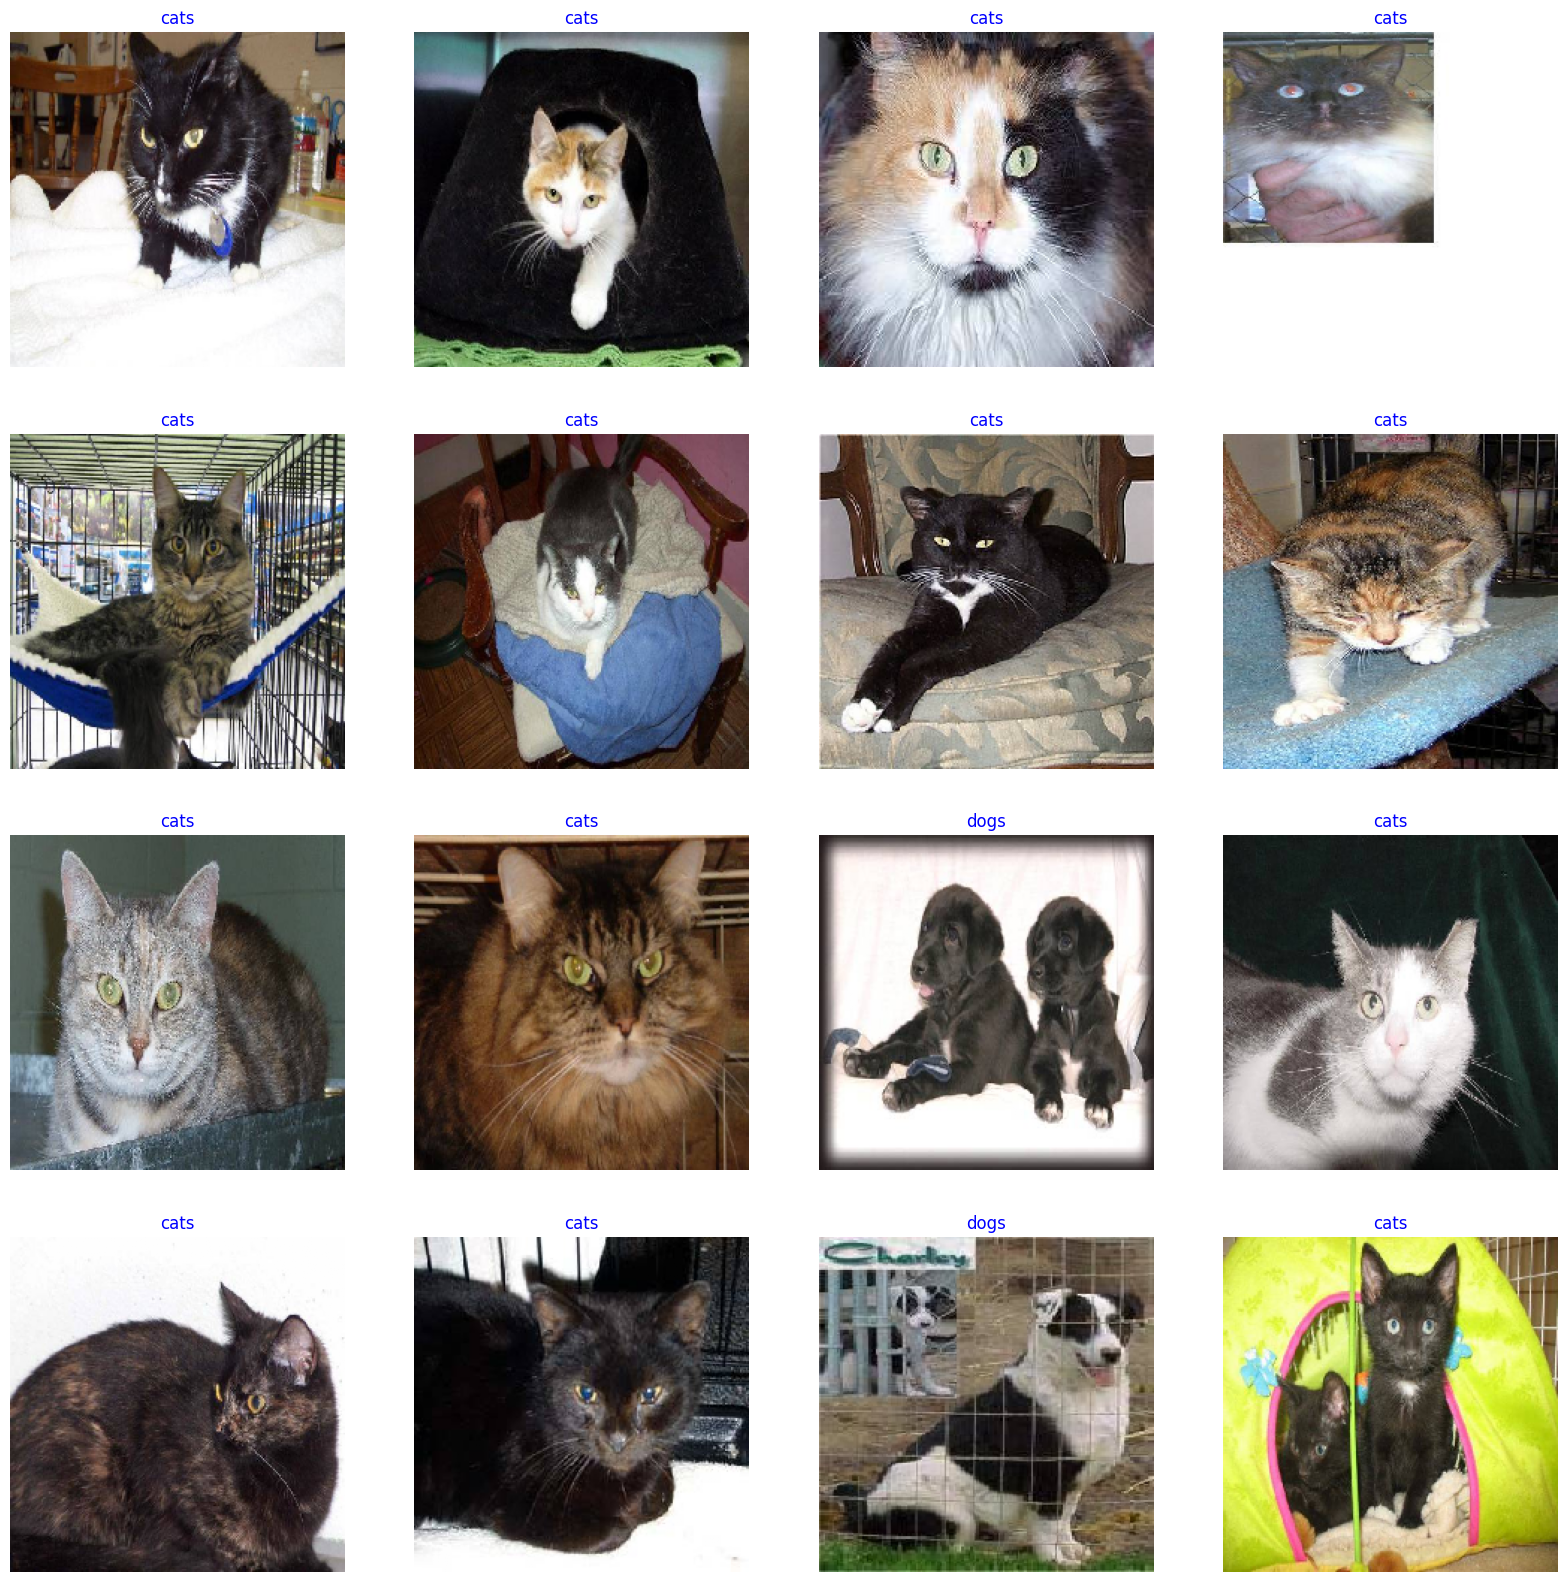

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False , weights= 'imagenet' ,
                                                               input_shape= img_shape,pooling= 'max')
base_model.trainable= False

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate = 0.4 , seed = 40),
    Dense(1 , activation= 'sigmoid' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'binary_crossentropy' , metrics= ['accuracy'])
model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 29,046,520
Trainable params: 528,897
Non-

In [ ]:
history = model.fit(x= train_gen , validation_data= valid_gen , epochs= 10 , verbose = 1 , validation_steps = None , shuffle = False)

Epoch 1/10


2023-09-26 09:29:06.722580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


626/626 [==============================] - 177s 242ms/step - loss: 2.0322 - accuracy: 0.9811 - val_loss: 0.4405 - val_accuracy: 0.9848
Epoch 2/10
626/626 [==============================] - 145s 231ms/step - loss: 0.3072 - accuracy: 0.9875 - val_loss: 0.2127 - val_accuracy: 0.9880
Epoch 3/10
626/626 [==============================] - 145s 231ms/step - loss: 0.1941 - accuracy: 0.9880 - val_loss: 0.1608 - val_accuracy: 0.9856
Epoch 4/10
626/626 [==============================] - 145s 231ms/step - loss: 0.1574 - accuracy: 0.9868 - val_loss: 0.1357 - val_accuracy: 0.9872
Epoch 5/10
626/626 [==============================] - 145s 231ms/step - loss: 0.1413 - accuracy: 0.9867 - val_loss: 0.1266 - val_accuracy: 0.9864
Epoch 6/10
626/626 [==============================] - 145s 231ms/step - loss: 0.1302 - accuracy: 0.9869 - val_loss: 0.1184 - val_accuracy: 0.9864
Epoch 7/10
626/626 [==============================] - 145s 231ms/step - loss: 0.1219 - accuracy: 0.9894 - val_loss: 0.1134 - val_accura

## Model Performance

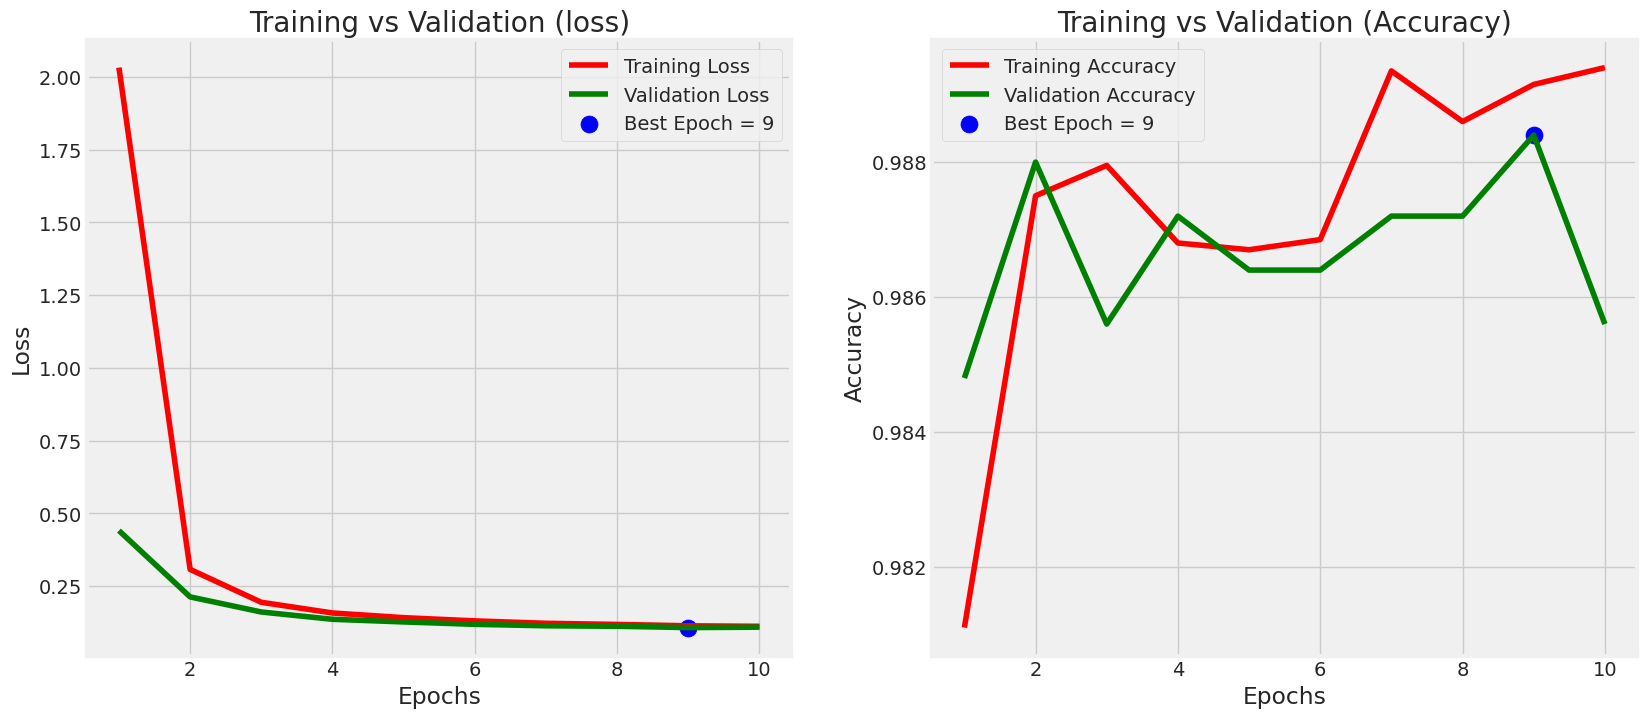

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

## Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 7s 202ms/step - loss: 0.0916 - accuracy: 0.9883
Train loss = 0.09045346826314926
Train Accuracy = 0.9951171875
Validation loss = 0.1115003302693367
Validation Accuracy = 0.984375
Test loss = 0.09160945564508438
Test Accuracy = 0.98828125


## Model Prediction

## Confusion Matrix and Classification Report

In [ ]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

79/79 [==============================] - 15s 196ms/step


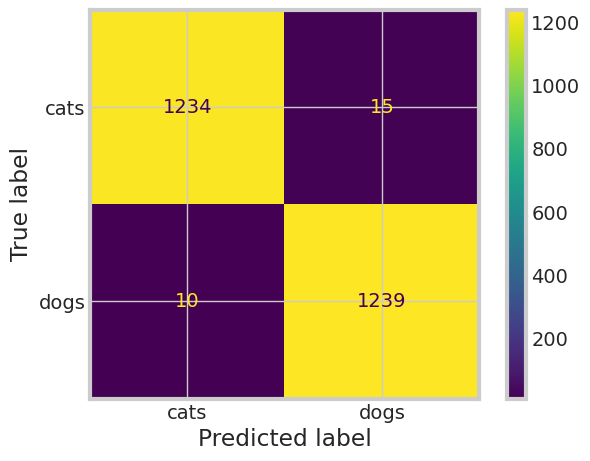

In [ ]:
# Get the true labels from the generator
true_classes = test_gen.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='viridis', values_format='d')

In [ ]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1249
        dogs       0.99      0.99      0.99      1249

    accuracy                           0.99      2498
   macro avg       0.99      0.99      0.99      2498
weighted avg       0.99      0.99      0.99      2498

